In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans, Birch

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import Perceptron
from sklearn.metrics import make_scorer
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier

import advanced_processor_chain_factory
from data import preprocess_data, load_dataset
from evaluation import analysis, cluster_analysis

In [2]:
def last_layer_activations(model, X):
    acs = [X] + (model.n_layers_ - 1) * [None]
    return model._forward_pass(acs)[model.n_layers_ - 2]

In [3]:
dataset = load_dataset()
DEBUG = False

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(
    *preprocess_data(dataset, processor_chain=advanced_processor_chain_factory.create('lem'), debug=DEBUG))

Pandas Apply:   0%|          | 0/45000 [00:00<?, ?it/s]

In [5]:
vectorizer = CountVectorizer(max_features=2000)

In [6]:
vectorizer.fit(pd.concat([X_train, X_test]))
X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [7]:
mlp = MLPClassifier(hidden_layer_sizes=(1000, 500, 250, 5), activation='tanh', warm_start=True)
mlp.fit(X_train_vec, Y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=(1000, 500, 250, 5),
              warm_start=True)

In [8]:
analysis(Y_test, mlp.predict(X_test_vec))

Report: Classification
               precision    recall  f1-score   support

    positive       0.85      0.84      0.85      5686
    negative       0.84      0.85      0.85      5564

    accuracy                           0.85     11250
   macro avg       0.85      0.85      0.85     11250
weighted avg       0.85      0.85      0.85     11250

Matrix: Confusion
 [[4780  906]
 [ 815 4749]]
Accuracy:
 0.8470222222222222


0.8465995186736786

In [9]:
X_train_vec = last_layer_activations(mlp, X_train_vec)
X_test_vec = last_layer_activations(mlp, X_test_vec)

# Show Clusters

In [10]:
def plot_clustering(Y, X_train_pca):
    u_labels = np.unique(Y)
    for i in u_labels:
        points = X_train_pca[Y == i]
        plt.scatter(points[:, 0], points[:, 1], label=i)
    plt.show()

In [11]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_vec)
X_test_pca = pca.transform(X_test_vec)

# Plot Actual Data

Let's see something weird. Features generated by the multi-layer perceptron for train data, are perfect for
even one-dimensional clustering, but it seems they are not good at all for separating our test data.

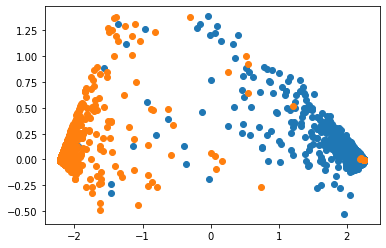

In [12]:
plot_clustering(Y_train, X_train_pca)

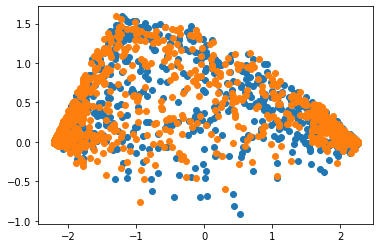

In [13]:
plot_clustering(Y_test, X_test_pca)

## (Bonus) Train a Logistic Regression with the New Representation
As the two-dimensional representation for transformed test data was a total disaster, we wondered to know if this data
is even predictable at all with a model trained with our transformed train data. So we decided to measure
test data performance on a Logistic Regression model trained on our transformed train data.
We measure train and test performance with conventional accuracy metric and with two clustering measures which will be
also used in the next part.

In [14]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_vec, Y_train)
for name, y, x in [('Training', Y_train, X_train_vec), ('Testing', Y_test, X_test_vec)]:
    print('%s Accuracy: %f' % (name, metrics.accuracy_score(y, lr.predict(x))))
    print('%s Rand Score: %f' % (name, metrics.rand_score(y, lr.predict(x))))
    print('%s Fowlkers Mallows Score: %f' % (name, metrics.fowlkes_mallows_score(y, lr.predict(x))))

Training Accuracy: 0.993274
Training Rand Score: 0.986638
Training Fowlkers Mallows Score: 0.986638
Testing Accuracy: 0.848622
Testing Rand Score: 0.743052
Testing Fowlkers Mallows Score: 0.743052


In [15]:
def plot_cv_results(results, x_name):
    plt.xlabel(x_name)
    plt.ylabel("Score")
    ax = plt.gca()
    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results['param_%s' % x_name].data, dtype=float)

    for scorer, color in zip(sorted(scoring), ['g', 'k']):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
            sample_score_std = results['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                            sample_score_mean + sample_score_std,
                            alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label="%s (%s)" % (scorer, sample))

    plt.legend(loc="best")
    plt.grid(False)
    plt.show()

In [16]:
scoring = {'rand_score': make_scorer(metrics.rand_score),
           'fowlkes_mallows_score': make_scorer(metrics.fowlkes_mallows_score)}
cols2show = ['mean_test_rand_score',
             'rank_test_rand_score',
             'mean_train_rand_score',
             'mean_test_fowlkes_mallows_score',
             'rank_test_fowlkes_mallows_score',
             'mean_train_fowlkes_mallows_score']

# Birch

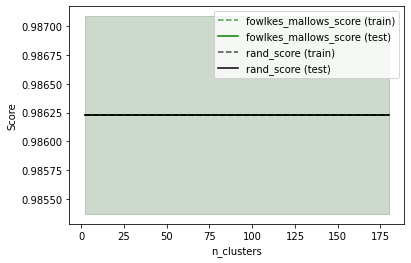

In [17]:
birtch = Birch()
n_clusters = list(range(2, 11, 2)) + [20 * i for i in range(1, 10)]
birtch = GridSearchCV(birtch, {'n_clusters': n_clusters}, scoring=scoring, refit='rand_score', return_train_score=True,
                      cv=3, n_jobs=-1)
birtch.fit(X_train_vec, Y_train)
plot_cv_results(birtch.cv_results_, 'n_clusters')
results = pd.DataFrame(birtch.cv_results_)[cols2show + ['param_n_clusters']]

In [18]:
cluster_analysis(Y_test, birtch.predict(X_test_vec))

Test Evaluation:
rand_score: 0.7414431860609833
fowlkes_mallows_score: 0.7414952325445504


In [19]:
results[results['rank_test_rand_score'] == 1].head()

,mean_test_rand_score,rank_test_rand_score,mean_train_rand_score,mean_test_fowlkes_mallows_score,rank_test_fowlkes_mallows_score,mean_train_fowlkes_mallows_score,param_n_clusters
0,0.986229,1,0.986229,0.986229,1,0.986229,2
1,0.986229,1,0.986229,0.986229,1,0.986229,4
2,0.986229,1,0.986229,0.986229,1,0.986229,6
3,0.986229,1,0.986229,0.986229,1,0.986229,8
4,0.986229,1,0.986229,0.986229,1,0.986229,10


In [20]:
results[results['rank_test_fowlkes_mallows_score'] == 1].head()

,mean_test_rand_score,rank_test_rand_score,mean_train_rand_score,mean_test_fowlkes_mallows_score,rank_test_fowlkes_mallows_score,mean_train_fowlkes_mallows_score,param_n_clusters
0,0.986229,1,0.986229,0.986229,1,0.986229,2
1,0.986229,1,0.986229,0.986229,1,0.986229,4
2,0.986229,1,0.986229,0.986229,1,0.986229,6
3,0.986229,1,0.986229,0.986229,1,0.986229,8
4,0.986229,1,0.986229,0.986229,1,0.986229,10


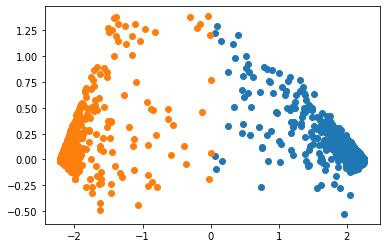

In [21]:
plot_clustering(birtch.predict(X_train_vec), X_train_pca)

# KMeans

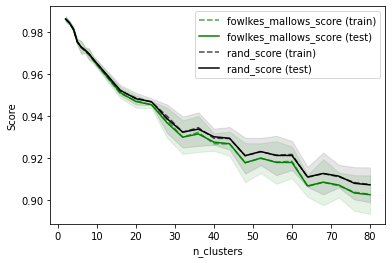

In [22]:
n_clusters = list(range(2, 10)) + [4 * i for i in range(4, 21)]
kmeans = KMeans()
kmeans = GridSearchCV(kmeans, {'n_clusters': n_clusters}, scoring=scoring, refit='rand_score', return_train_score=True,
                      n_jobs=-1)
kmeans.fit(X_train_vec, Y_train)
plot_cv_results(kmeans.cv_results_, 'n_clusters')
results = pd.DataFrame(kmeans.cv_results_)[cols2show + ['param_n_clusters']]

In [23]:
cluster_analysis(Y_test, kmeans.predict(X_test_vec))

Test Evaluation:
rand_score: 0.7414431860609833
fowlkes_mallows_score: 0.7414952325445504


In [24]:
results[results['rank_test_rand_score'] == 1]

,mean_test_rand_score,rank_test_rand_score,mean_train_rand_score,mean_test_fowlkes_mallows_score,rank_test_fowlkes_mallows_score,mean_train_fowlkes_mallows_score,param_n_clusters
0,0.986228,1,0.986229,0.986229,1,0.986229,2


In [25]:
results[results['rank_test_fowlkes_mallows_score'] == 1]

,mean_test_rand_score,rank_test_rand_score,mean_train_rand_score,mean_test_fowlkes_mallows_score,rank_test_fowlkes_mallows_score,mean_train_fowlkes_mallows_score,param_n_clusters
0,0.986228,1,0.986229,0.986229,1,0.986229,2


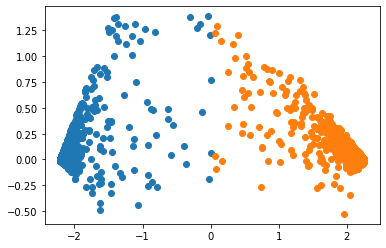

In [26]:
plot_clustering(kmeans.predict(X_train_vec), X_train_pca)

# GMM

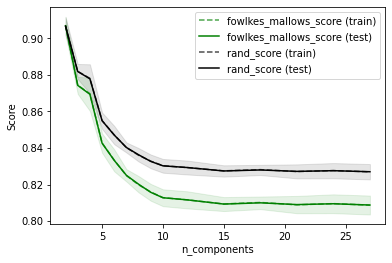

In [27]:
gmm = GaussianMixture()
gmm = GridSearchCV(gmm, {'n_components': list(range(2, 11)) + [3 * i for i in range(4, 10)]}, scoring=scoring,
                   refit='rand_score', return_train_score=True, n_jobs=-1)
gmm.fit(X_train_vec, Y_train)
plot_cv_results(gmm.cv_results_, 'n_components')
results = pd.DataFrame(gmm.cv_results_)[cols2show + ['param_n_components']]

In [28]:
cluster_analysis(Y_test, gmm.predict(X_test_vec))

Test Evaluation:
rand_score: 0.7038644659772226
fowlkes_mallows_score: 0.7104852861202803


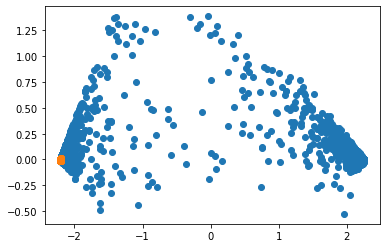

In [29]:
plot_clustering(gmm.predict(X_train_vec), X_train_pca)

In [30]:
results[results['rank_test_rand_score'] == 1]

,mean_test_rand_score,rank_test_rand_score,mean_train_rand_score,mean_test_fowlkes_mallows_score,rank_test_fowlkes_mallows_score,mean_train_fowlkes_mallows_score,param_n_components
0,0.906576,1,0.906706,0.906869,1,0.90699,2


In [31]:
results[results['rank_test_fowlkes_mallows_score'] == 1]

,mean_test_rand_score,rank_test_rand_score,mean_train_rand_score,mean_test_fowlkes_mallows_score,rank_test_fowlkes_mallows_score,mean_train_fowlkes_mallows_score,param_n_components
0,0.906576,1,0.906706,0.906869,1,0.90699,2


# Cluster Member's Similarity in Action

In [32]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_vec)
Y_train_pred = kmeans.predict(X_train_vec)

Cluster 0:
0	american humane association source familiar disclaimer animal harm register trademark aha begin monitor use animal film production year ago blindfold horse force leap death top cliff shoot film jesse james needless say atrocious act kill whole entertainment aspect film suppose one could say least horse not die vain since begin public wake callous horrendous pain cause animal glory movie making can not help feel poor animal choice sure would not path would take
1	set near future dark strange walks southern american city plague zombie settle group friendly face inhabitant stranger learn harsh reality city life two group people upper class dwell safely behind concrete wall city provide right price state police friendly face inhabitant low class folk live along side zombie mean survival trade good forage day police exchange tin food stranger discover world plague zombies new dietary pill suppress craving carbohydrate foundation human race desire would fat cause fall society kn

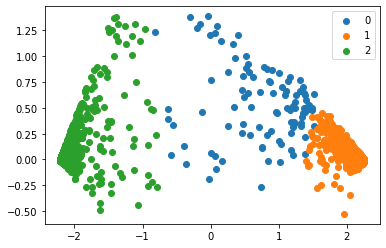

In [33]:
for i in range(3):
    print(f'Cluster {i}:')
    points = X_train_pca[Y_train_pred == i]
    plt.scatter(points[:, 0], points[:, 1], label=i)
    for i, item in enumerate(X_train[Y_train_pred == i].head(5)):
        print(f'{i}\t{item}')
plt.legend()
plt.show()

# Fine-Tuning

## Without pre-training

In [34]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1uykBJxWH5v5BsSuuwM0r9WLiKWQrDiDJ', dest_path=('./dataset2.csv'))
dataset2 = pd.read_csv('./dataset2.csv')

In [35]:
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(
    *preprocess_data(dataset2, processor_chain=advanced_processor_chain_factory.create('lem'), debug=False))

Pandas Apply:   0%|          | 0/500 [00:00<?, ?it/s]

In [36]:
vectorizer2 = CountVectorizer(max_features=2000)
vectorizer2.fit(pd.concat([X_train2, X_test2]))
X_train_vec2 = vectorizer2.transform(X_train2)
X_test_vec2 = vectorizer2.transform(X_test2)

In [37]:
model = MLPClassifier(hidden_layer_sizes=(1000, 500, 250, 5), activation='tanh')
model.fit(X_train_vec2, Y_train2)
analysis(Y_test2, model.predict(X_test_vec2))

Report: Classification
               precision    recall  f1-score   support

    positive       0.72      0.85      0.78        62
    negative       0.82      0.67      0.74        63

    accuracy                           0.76       125
   macro avg       0.77      0.76      0.76       125
weighted avg       0.77      0.76      0.76       125

Matrix: Confusion
 [[53  9]
 [21 42]]
Accuracy:
 0.76


/home/mryf/PycharmProjects/ml_final_project/venv/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.7368421052631577

## With pre-training

In [38]:
X_train_vec2 = vectorizer.transform(X_train2)
X_test_vec2 = vectorizer.transform(X_test2)

In [39]:
mlp.partial_fit(X_train_vec2, Y_train2)
analysis(Y_test2, mlp.predict(X_test_vec2))

Report: Classification
               precision    recall  f1-score   support

    positive       0.81      0.71      0.76        62
    negative       0.75      0.84      0.79        63

    accuracy                           0.78       125
   macro avg       0.78      0.78      0.77       125
weighted avg       0.78      0.78      0.77       125

Matrix: Confusion
 [[44 18]
 [10 53]]
Accuracy:
 0.776


0.791044776119403